In [33]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [34]:
def load_and_show_markers(ann_path: str, raw=None):
    """
    Load markers from annotation file and display them in a table
    Returns the loaded markers list. If no valid markers found, uses raw data duration.
    """
    def format_time(time_sec):
        """Convert seconds to MM:SS.mmm format"""
        minutes = int(time_sec // 60)
        seconds = int(time_sec % 60)
        milliseconds = int((time_sec % 1) * 1000)
        return f"{minutes:02d}:{seconds:02d}.{milliseconds:03d}"
    
    markers = []
    
    # Try to load annotations if file exists
    if Path(ann_path).exists():
        with open(ann_path, 'r', encoding='cp1251') as f:
            lines = f.readlines()
            # Skip header
            for line in lines[1:]:  # Skip the first "EventTable V2.0" line
                if line.strip():
                    try:
                        # Split by comma as we can see in the .ann file
                        parts = line.strip().split(',')
                        if len(parts) >= 2:
                            markers.append({
                                'time': float(parts[0]) / 1000.0,  # Convert to seconds from milliseconds
                                'type': parts[1],
                                'description': parts[3] if len(parts) > 3 else ''
                            })
                    except (ValueError, IndexError) as e:
                        print(f"Skipping invalid line: {line.strip()}")
                        continue
    
    # Display table
    print("\nMarker Index Reference Table:")
    print("-" * 50)
    print(f"{'Index':<8} {'Time':<12} {'Description':<30}")
    print("-" * 50)
    
    # Show start of file
    print(f"0        00:00.000    Start of file")
    
    # Show all markers if any exist
    for i, marker in enumerate(markers, 1):
        time_str = format_time(marker['time'])
        print(f"{i:<8} {time_str:<12} Marker {i}")
    
    # Show end of file using raw data duration
    if raw is not None:
        duration = raw.times[-1]  # Get actual duration from raw data
    else:
        print("Warning: No raw data provided to determine file duration")
        return []
        
    end_time_str = format_time(duration)
    print(f"{len(markers)+1:<8} {end_time_str:<12} End of file")
    
    print("-" * 50)
    
    return markers

In [35]:
def load_experiment_files(folder_path: str):
    """
    Load .edf, .ann, and .ini files from the specified folder
    """
    folder = Path(folder_path)
    
    # Find files with matching names but different extensions
    edf_files = list(folder.glob("*.edf"))
    if not edf_files:
        raise FileNotFoundError("No .edf files found in the specified folder")
    
    # Take the first .edf file and use its stem to find corresponding files
    base_name = edf_files[0].stem
    
    edf_path = folder / f"{base_name}.edf"
    ann_path = folder / f"{base_name}.ann"
    ini_path = folder / f"{base_name}.ini"
    
    # Load EDF file
    raw = mne.io.read_raw_edf(edf_path, preload=True)
    
    # Load markers and show table
    markers = load_and_show_markers(ann_path, raw)
    
    return raw, markers

In [36]:
def extract_marked_data(raw, markers, start_index, end_index, epoch_duration=4.0, overlap=3.0):
    """
    Extract data between specified indices and split into overlapping epochs
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Raw EEG data
    markers : list
        List of markers with timestamps
    start_index : int
        Starting index (0 = file start, 1 to n = markers, n+1 = file end)
    end_index : int
        Ending index (0 = file start, 1 to n = markers, n+1 = file end)
    epoch_duration : float
        Duration of each epoch in seconds
    overlap : float
        Overlap duration between epochs in seconds
    """
    # Get total duration of the recording
    total_duration = raw.times[-1]
    
    # Create list of all possible time points (start, markers, end)
    time_points = [0.0] + [m['time'] for m in markers] + [total_duration]
    
    # Validate indices
    if start_index < 0 or end_index > len(time_points)-1:
        raise ValueError(f"Indices must be between 0 and {len(time_points)-1}")
    if start_index >= end_index:
        raise ValueError("Start index must be less than end index")
    
    # Get start and end times based on indices
    start_time = time_points[start_index]
    end_time = time_points[end_index]
    
    # Process data
    epochs_data = []
    sfreq = raw.info['sfreq']
    samples_per_epoch = int(epoch_duration * sfreq)
    samples_per_overlap = int(overlap * sfreq)
    step_size = samples_per_epoch - samples_per_overlap
    
    # Convert times to samples
    start_sample = int(start_time * sfreq)
    end_sample = int(end_time * sfreq)
    
    # Extract data segment
    segment_data, _ = raw[:, start_sample:end_sample]
    
    # Create overlapping epochs
    n_epochs = (segment_data.shape[1] - samples_per_epoch) // step_size + 1
    for j in range(n_epochs):
        start_idx = j * step_size
        end_idx = start_idx + samples_per_epoch
        if end_idx <= segment_data.shape[1]:
            epochs_data.append(segment_data[:, start_idx:end_idx])
    
    return np.array(epochs_data)

In [37]:
def plot_averaged_epochs(epochs_data, raw, epoch_duration=4.0):
    """
    Average epochs and plot results for each electrode
    """
    # Average across epochs
    averaged_data = np.mean(epochs_data, axis=0)
    
    # Create time array for x-axis
    time_points = np.linspace(0, epoch_duration, averaged_data.shape[1])
    
    # Plot each channel
    n_channels = averaged_data.shape[0]
    fig, axes = plt.subplots(n_channels, 1, figsize=(15, 3*n_channels))
    
    if n_channels == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.plot(time_points, averaged_data[i], 'b-')
        ax.set_title(f'Channel {raw.ch_names[i]}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [38]:
def plot_spectrograms(epochs_data, raw, epoch_duration=4.0):
    """
    Compute and plot averaged spectrograms for each channel
    """
    from scipy import signal
    
    # Calculate average spectrogram across epochs
    sfreq = raw.info['sfreq']
    n_channels = epochs_data.shape[1]
    
    # Parameters for spectrogram
    nperseg = int(sfreq)  # 1-second window
    noverlap = nperseg // 2  # 50% overlap
    
    # Create subplot for each channel
    fig, axes = plt.subplots(n_channels, 1, figsize=(15, 4*n_channels))
    if n_channels == 1:
        axes = [axes]
    
    for ch_idx in range(n_channels):
        # Average spectrogram across epochs
        avg_spectrogram = None
        
        for epoch in epochs_data:
            frequencies, times, Sxx = signal.spectrogram(
                epoch[ch_idx], 
                fs=sfreq,
                nperseg=nperseg,
                noverlap=noverlap,
                window='hann'
            )
            
            if avg_spectrogram is None:
                avg_spectrogram = Sxx
            else:
                avg_spectrogram += Sxx
        
        avg_spectrogram /= len(epochs_data)
        
        # Plot
        im = axes[ch_idx].pcolormesh(times, frequencies, 10 * np.log10(avg_spectrogram),
                                    shading='gouraud', cmap='viridis')
        axes[ch_idx].set_ylabel('Frequency [Hz]')
        axes[ch_idx].set_title(f'Channel {raw.ch_names[ch_idx]}')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[ch_idx])
        cbar.set_label('Power/Frequency [dB/Hz]')
        
        # Set y-axis limit to show frequencies up to 50 Hz
        axes[ch_idx].set_ylim(0, 50)
    
    axes[-1].set_xlabel('Time [s]')
    plt.tight_layout()
    plt.show()

In [39]:
def plot_power_spectrum(epochs_data, raw, epoch_duration=4.0):
    """
    Compute and plot averaged power spectrum (FFT) for each channel
    With specific frequency range (0-30 Hz) and amplitude in microvolts (0-7)
    """
    # Calculate FFT parameters
    sfreq = raw.info['sfreq']
    n_channels = epochs_data.shape[1]
    
    # Compute frequency axis
    n_points = epochs_data.shape[2]
    freq_axis = np.fft.rfftfreq(n_points, d=1/sfreq)
    
    # Create subplot for each channel
    fig, axes = plt.subplots(n_channels, 1, figsize=(15, 4*n_channels))
    if n_channels == 1:
        axes = [axes]
    
    for ch_idx in range(n_channels):
        # Average FFT across epochs
        avg_spectrum = np.zeros_like(freq_axis, dtype=float)
        
        for epoch in epochs_data:
            # Apply Hanning window
            windowed_data = epoch[ch_idx] * np.hanning(len(epoch[ch_idx]))
            # Compute FFT and convert to microvolts
            spectrum = np.abs(np.fft.rfft(windowed_data)) * 2.0 / n_points  # Scaling to get amplitude in original units
            avg_spectrum += spectrum
        
        avg_spectrum /= len(epochs_data)

        
        # Plot
        axes[ch_idx].plot(freq_axis, avg_spectrum)
        axes[ch_idx].set_xlabel('Frequency [Hz]')
        axes[ch_idx].set_ylabel('Amplitude [µV]')
        axes[ch_idx].set_title(f'Channel {raw.ch_names[ch_idx]}')
        
        # Set axes limits
        axes[ch_idx].set_xlim(0, 30)  # Display up to 30 Hz
        axes[ch_idx].set_ylim(0, 7)   # Set amplitude range 0-7 µV
        axes[ch_idx].grid(True)
        
        # Add frequency band markers
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30)
        }
        
        y_pos = 6.5  # Position for band labels
        for band, (fmin, fmax) in bands.items():
            axes[ch_idx].axvspan(fmin, fmax, alpha=0.2, color='gray')
            axes[ch_idx].text((fmin + fmax)/2, y_pos, band, 
                            horizontalalignment='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [52]:
# Main execution
FOLDER_PATH = "ЭЭГ Артем\Спокойное бодрствование"  # Replace with your path
EPOCH_DURATION = 4.0  # seconds
OVERLAP = 3.0  # seconds

# Load data
raw, markers = load_experiment_files(FOLDER_PATH)

# Extract data between markers
epochs_data = extract_marked_data(raw, markers, 
                                start_index=0, 
                                end_index=1,
                                epoch_duration=EPOCH_DURATION, 
                                overlap=OVERLAP)


Extracting EDF parameters from c:\Users\timof\Downloads\EEG_data\ЭЭГ Артем\Спокойное бодрствование\eeg_data2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 168399  =      0.000 ...   168.399 secs...

Marker Index Reference Table:
--------------------------------------------------
Index    Time         Description                   
--------------------------------------------------
0        00:00.000    Start of file
1        01:12.920    Marker 1
2        01:30.760    Marker 2
3        02:48.399    End of file
--------------------------------------------------


C:\Users\timof\AppData\Local\Temp\ipykernel_3616\4118483604.py:20: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
C:\Users\timof\AppData\Local\Temp\ipykernel_3616\4118483604.py:20: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


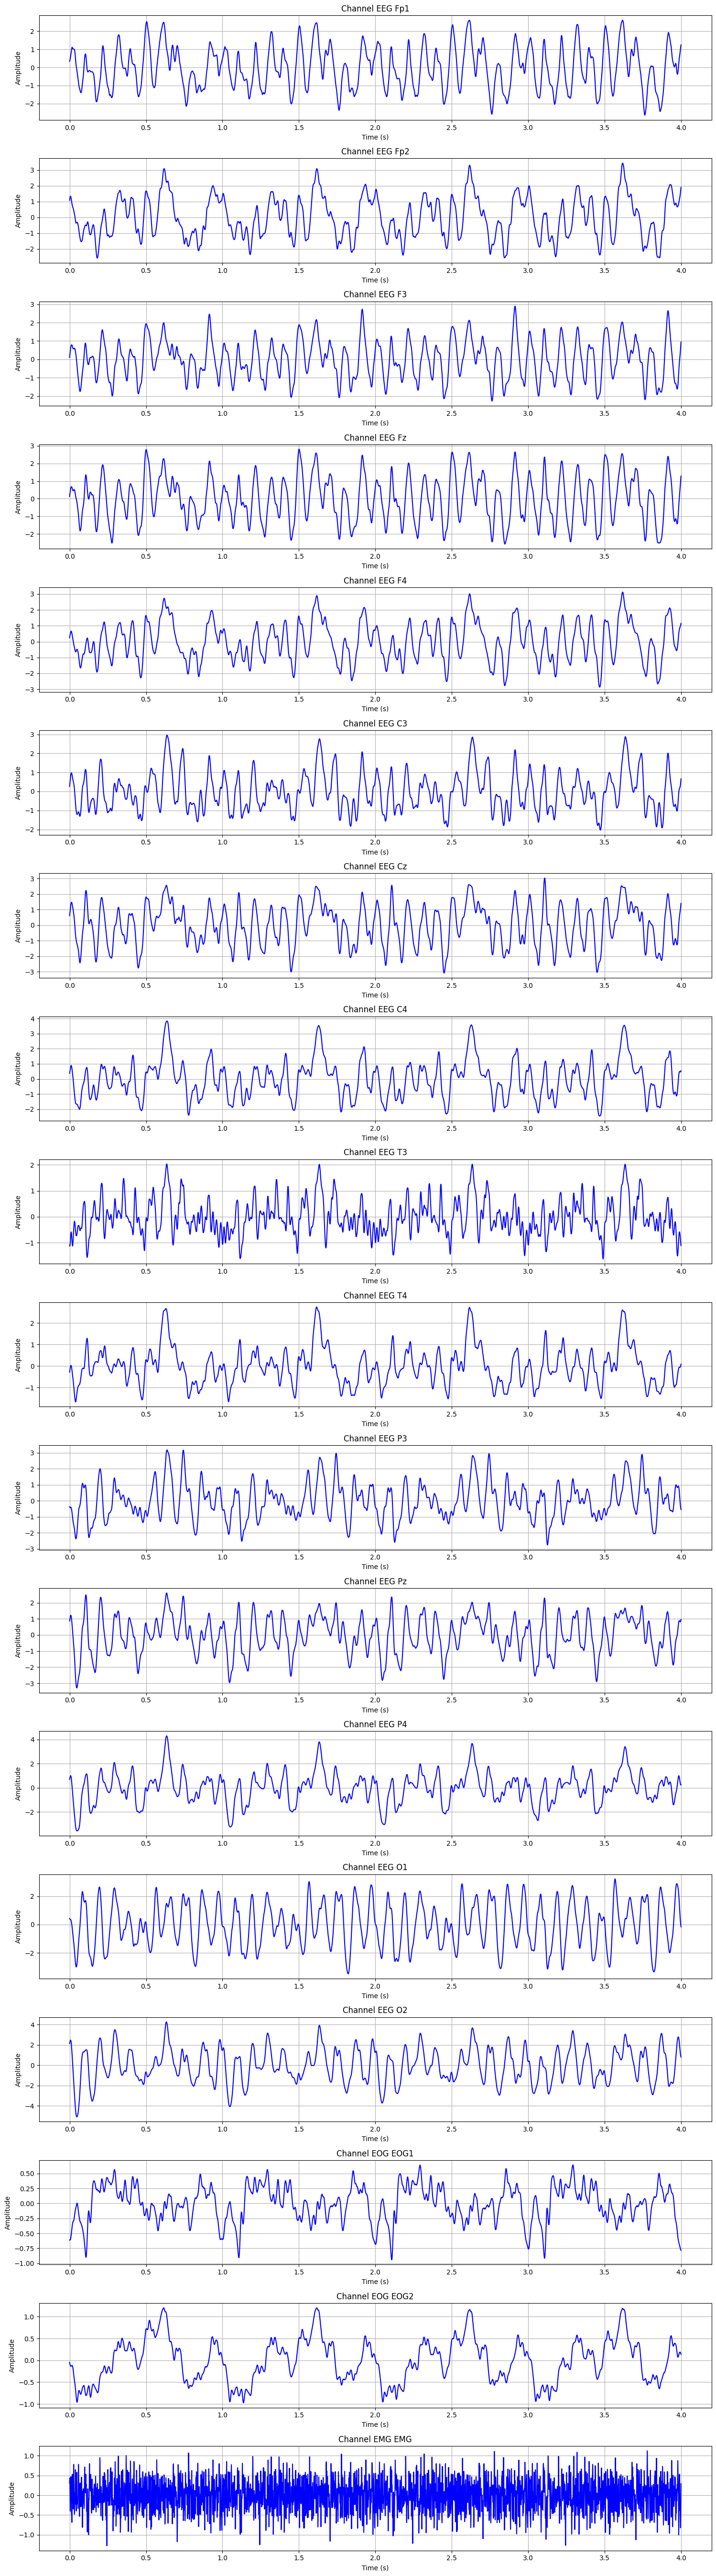

In [53]:
plot_averaged_epochs(epochs_data, raw, epoch_duration=4.0)

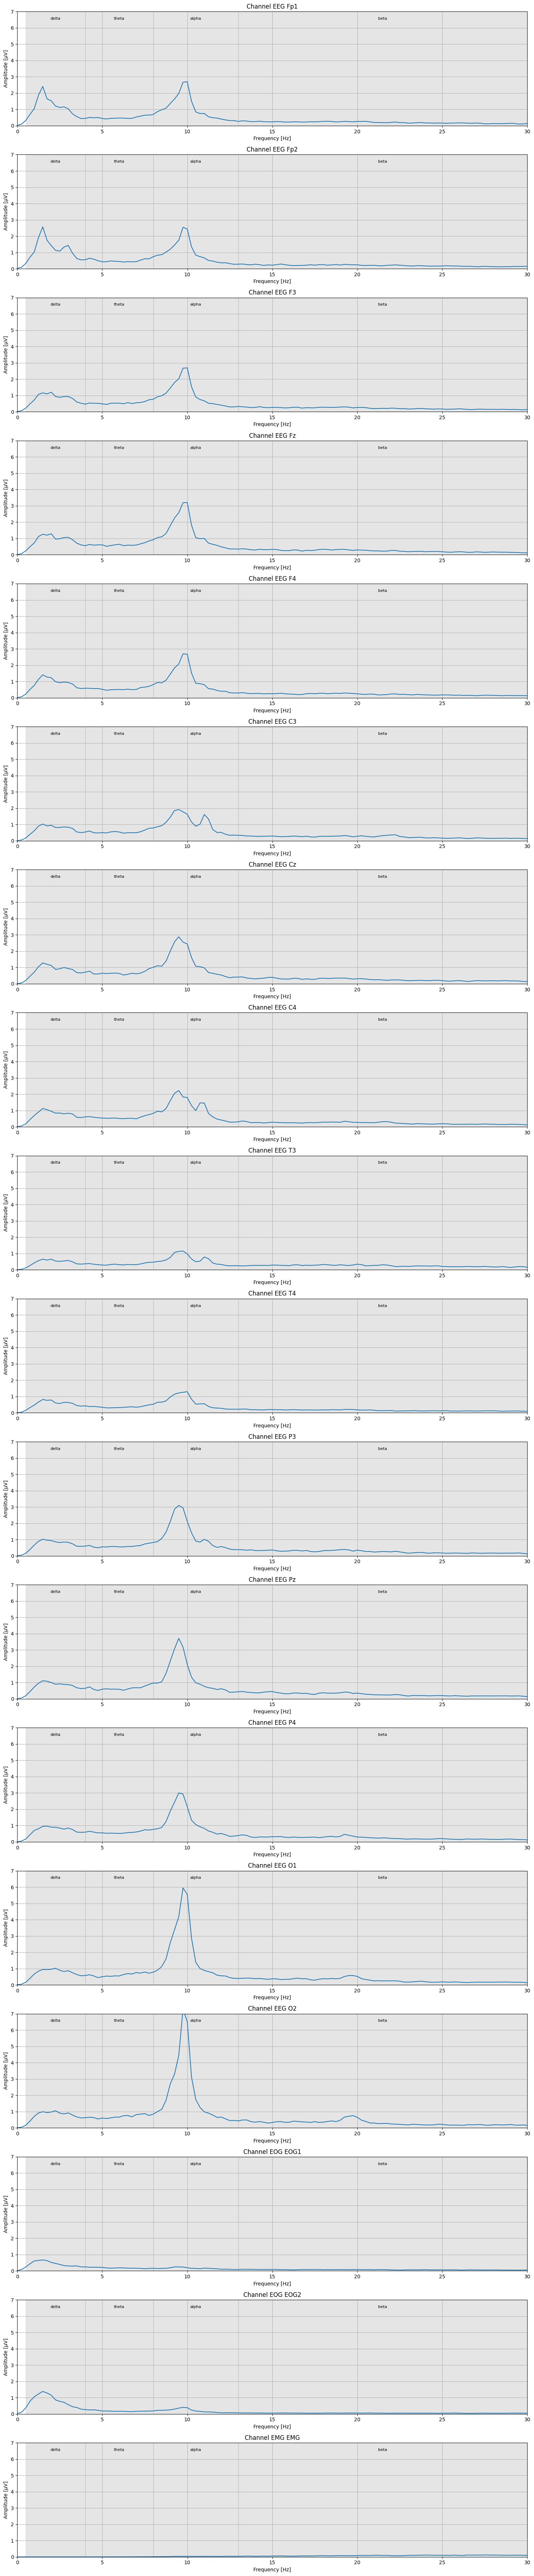

In [54]:
# Plot power spectrum
plot_power_spectrum(epochs_data, raw, EPOCH_DURATION)

In [55]:
def plot_amplitude_maps(epochs_data, raw, epoch_duration=4.0):
    """
    Create topographic maps of amplitude distribution for all standard frequency bands,
    normalizing the sum of amplitudes within each band by the number of frequency bins.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import mne
    
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 7),
        'alpha': (7, 14),
        'beta': (13, 20),
        'beta-2': (20, 30),
        'alpha-1': (7, 9),
        'alpha-2': (9, 11.5),
        'alpha-3': (11.5, 14)
    }
    
    # Define channel positions manually (standard 10-20 system coordinates)
    ch_pos = {
        'EEG Fp1': [-0.308, 0.851],
        'EEG Fp2': [0.308, 0.851],
        'EEG F3': [-0.5, 0.526],
        'EEG Fz': [0, 0.526],
        'EEG F4': [0.5, 0.526],
        'EEG C3': [-0.736, 0],
        'EEG Cz': [0, 0],
        'EEG C4': [0.736, 0],
        'EEG T3': [-0.8, 0],
        'EEG T4': [0.8, 0],
        'EEG P3': [-0.5, -0.526],
        'EEG Pz': [0, -0.526],
        'EEG P4': [0.5, -0.526],
        'EEG O1': [-0.308, -0.851],
        'EEG O2': [0.308, -0.851],
    }
    
    # Calculate FFT parameters
    sfreq = raw.info['sfreq']
    n_points = epochs_data.shape[2]
    freq_axis = np.fft.rfftfreq(n_points, d=1/sfreq)
    freq_resolution = freq_axis[1] - freq_axis[0]  # Frequency resolution per bin
    
    # Filter out non-EEG channels and get their positions
    eeg_picks = [idx for idx, name in enumerate(raw.ch_names) if 'EEG' in name]
    eeg_ch_names = [raw.ch_names[idx] for idx in eeg_picks]
    pos = np.array([ch_pos[name] for name in eeg_ch_names])
    
    for band_name, freq_band in bands.items():
        # Calculate amplitude values for each channel
        amplitude_values = np.zeros(len(raw.ch_names))
        
        for ch_idx in range(len(raw.ch_names)):
            # Sum FFT across epochs
            total_spectrum = np.zeros_like(freq_axis, dtype=float)
            
            for epoch in epochs_data:
                # Apply Hanning window
                windowed_data = epoch[ch_idx] * np.hanning(len(epoch[ch_idx]))
                # Compute FFT
                spectrum = np.abs(np.fft.rfft(windowed_data)) * 2.0 / n_points / 20 # Amplitude, not power
                total_spectrum += spectrum
            
            # Get sum of amplitudes in the specified frequency band
            freq_mask = (freq_axis >= freq_band[0]) & (freq_axis <= freq_band[1])
            amplitude_sum = np.sum(total_spectrum[freq_mask])
            
            # Normalize amplitude by the number of frequency bins
            num_bins = np.sum(freq_mask)
            if num_bins > 0:
                amplitude_values[ch_idx] = amplitude_sum / num_bins
        
        # Extract EEG channel amplitude values
        eeg_amplitude_values = amplitude_values[eeg_picks]
        
        # Create new figure for each band
        fig = plt.figure(figsize=(8, 8))
        
        # Create axes with specific size and position
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
        
        # Plot topographic map
        im = mne.viz.plot_topomap(eeg_amplitude_values, pos,
                                  cmap='RdBu_r', sensors=True, 
                                  contours=24, outlines='head',
                                  axes=ax, show=False,
                                  vlim=(0, 24))  # Set consistent amplitude scale
        
        plt.title(f'{band_name.capitalize()} ({freq_band[0]}-{freq_band[1]} Hz)',
                  fontsize=16, pad=20)
        cbar = plt.colorbar(im[0], ax=ax, label='Amplitude (µV)')
        cbar.set_label('Amplitude (µV)', fontsize=12)
        plt.show()


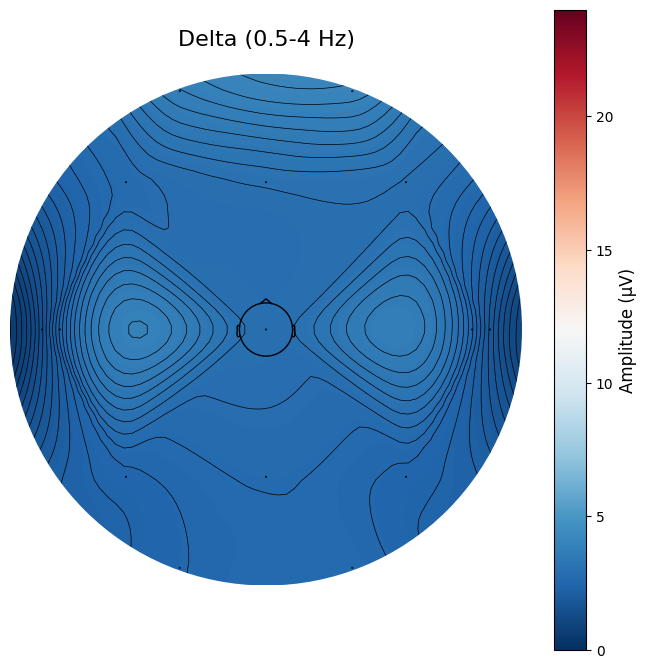

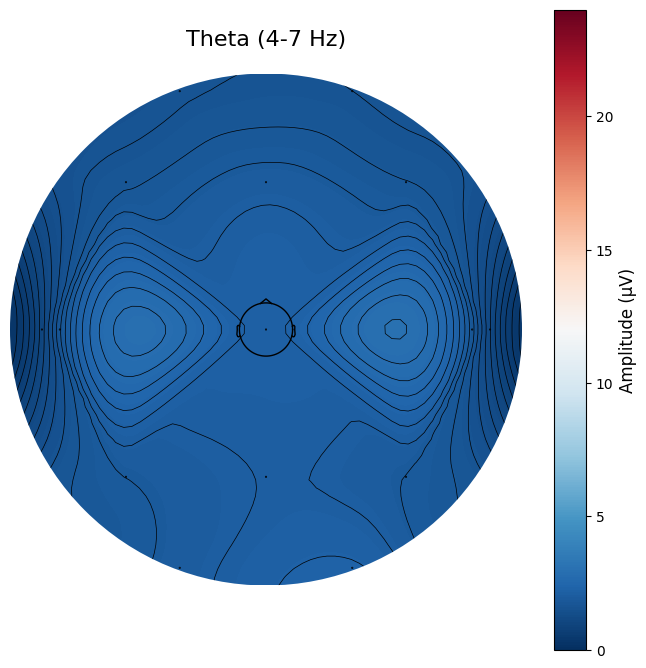

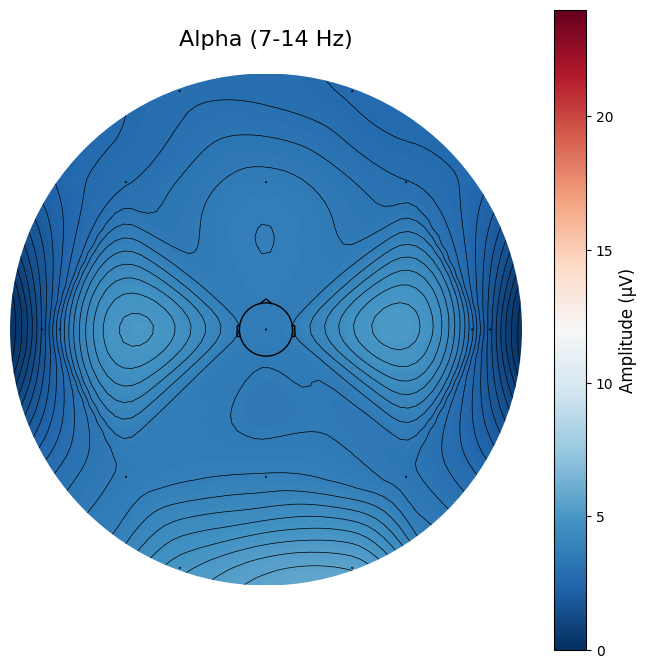

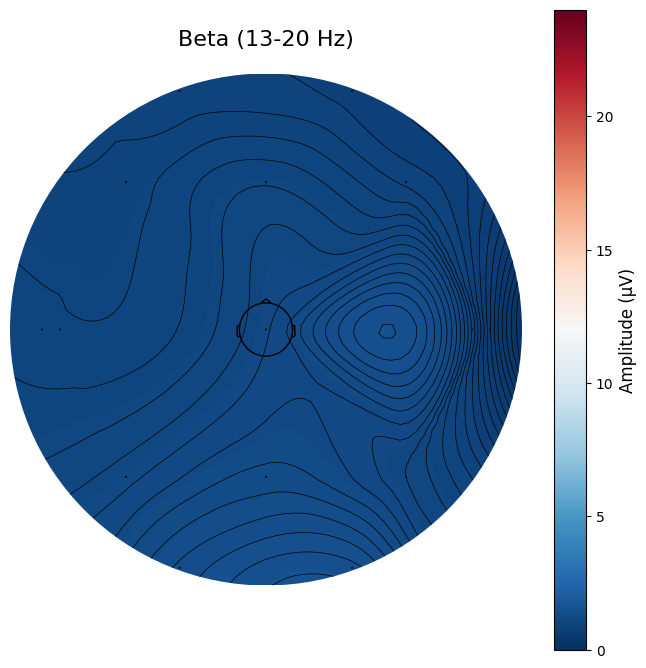

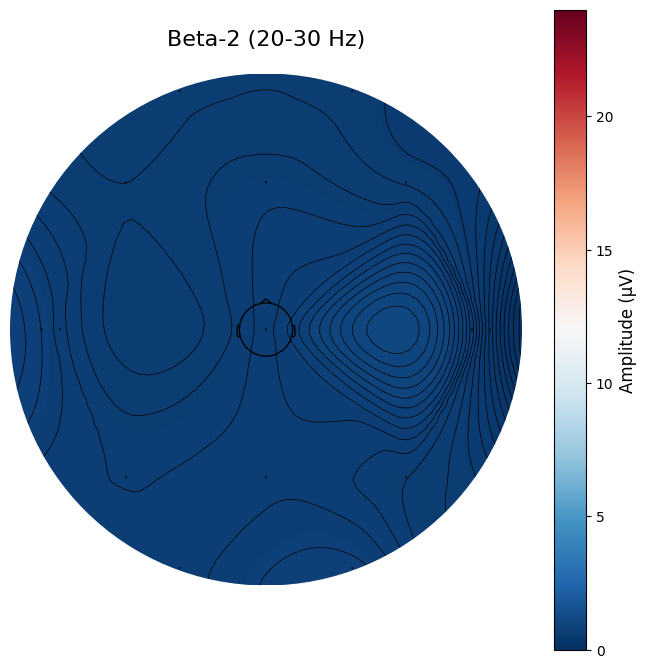

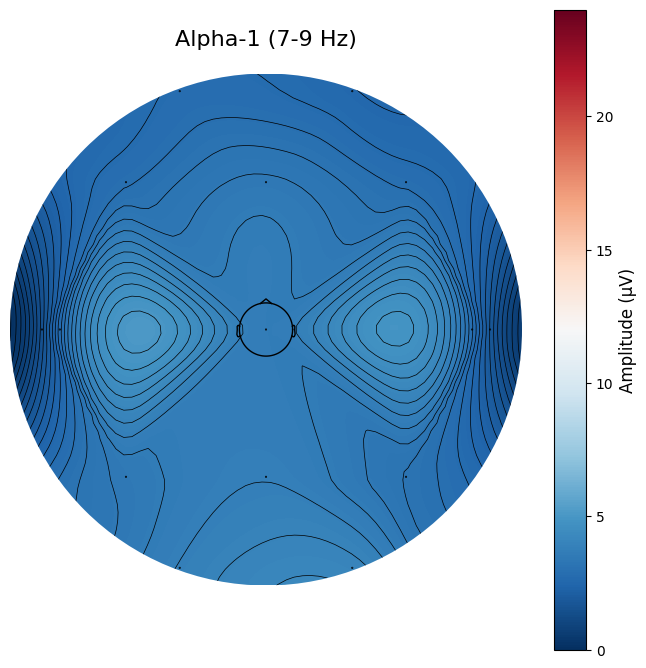

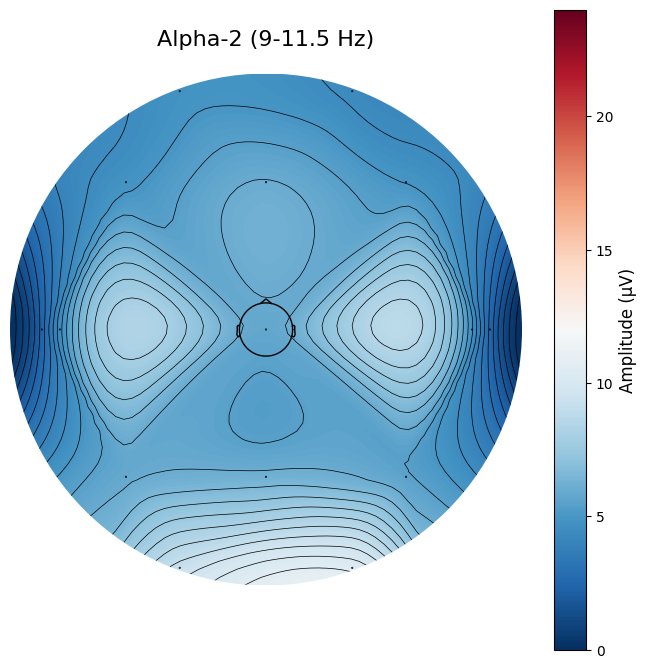

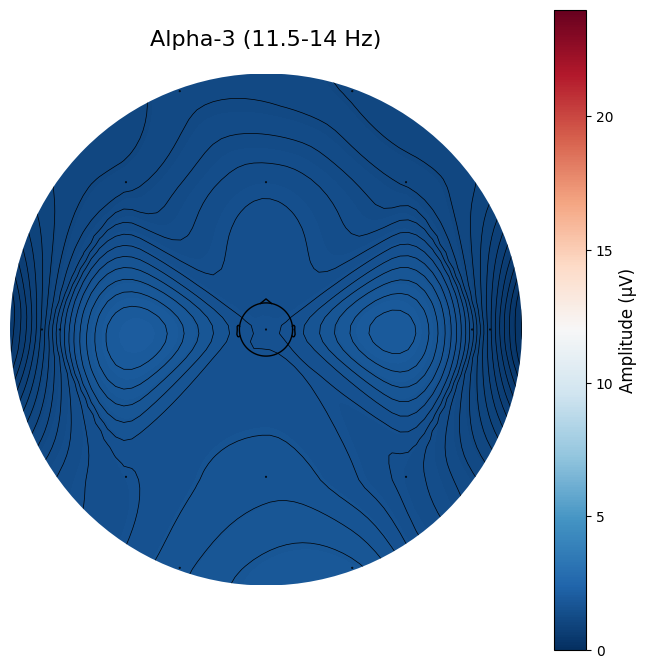

In [56]:
plot_amplitude_maps(epochs_data, raw, EPOCH_DURATION)